In [4]:
from pipeline.load_data import load_data
from pipeline.vocab import make_vocab
from graph_methods.create_graph import create_graphs
from pipeline.dataset import DocumentGraphDataset
from models.create_model import create_model
from pipeline.trainer import Trainer

from other_models.fasttext import evaluate_fasttext

from config import config, update_config
from scipy.sparse import coo_matrix
from collections import defaultdict
import os

In [5]:
update_config({'indices' : "1_3200train3200unlab800test"})
update_config({
    "graph_method" : {
        "name" : "pmi_tfidf",
        "kwargs" : {
            "window_size" : 10,
            "wordword_edges" : True,
            "worddoc_edges" : True,
            "docdoc_edges" : False,
            "average_wordword_conns" : None,
            "average_wordword_conns" : None, # or None for pmi > 0
        }
    },
})

In [6]:
docs, labels, tvt_idx = load_data()

dataset = DocumentGraphDataset(docs, labels, tvt_idx)

num_nodes = dataset.graph.num_nodes
num_edges = dataset.graph.num_edges

[load_data] Succesfully loaded 2880, 320, 800, 3200 data (7200 total)
[create_graph] Created a graph consisting of 25257 nodes and 9098915 edges
[dataset] Succesfully prepared PyTorch Geometric data 
Vocab size: 25257


In [7]:
# calc
num_doc_nodes = len(dataset.docs)

edges = dataset.graph.edge_index
print(edges)

a = coo_matrix(([1 for i in range(len(edges[0]))], (edges[0].numpy(), edges[1].numpy()))).toarray()

print(sum(sum(a)))

tensor([[ 9432, 24632, 12688,  ..., 25254, 25255, 25256],
        [24632,  9432, 24632,  ..., 25254, 25255, 25256]])
9098915


In [8]:
possible_edges = a.shape[0] * a.shape[1]
filled_edges = sum(sum(a))

perc = filled_edges / possible_edges

print("Each node is connected to on average %i nodes (%.1f%%), " % (filled_edges/a.shape[0], perc*100))

Each node is connected to on average 360 nodes (1.4%), 


In [9]:
dd_possible_edges = (num_doc_nodes) * (num_doc_nodes)
dd_filled_edges = sum(sum(a[:num_doc_nodes, :num_doc_nodes]))

dd_perc = dd_filled_edges / dd_possible_edges

print("Each doc is connected to on average %i docs (%.1f%%), " % (dd_filled_edges/num_doc_nodes, dd_perc*100))

Each doc is connected to on average 1 docs (0.0%), 


In [10]:
dw_possible_edges = (num_doc_nodes) * (a.shape[1]-num_doc_nodes)
dw_filled_edges = sum(sum(a[:num_doc_nodes, num_doc_nodes:]))

dw_perc = dw_filled_edges / dw_possible_edges

print("Each doc is connected to on average %i words (%.1f%%), " % (dw_filled_edges/num_doc_nodes, dw_perc*100))
print("Each word is connected to on average %i docs (%.1f%%), " % (dw_filled_edges/(a.shape[1]-num_doc_nodes), dw_perc*100))

Each doc is connected to on average 104 words (0.6%), 
Each word is connected to on average 41 docs (0.6%), 


In [11]:
ww_possible_edges = (a.shape[0]-num_doc_nodes) * (a.shape[1]-num_doc_nodes)
ww_filled_edges = sum(sum(a[num_doc_nodes:, num_doc_nodes:]))

ww_perc = ww_filled_edges / ww_possible_edges

print("Each word is connected to on average %i words (%.1f%%), " % (ww_filled_edges/(a.shape[0]-num_doc_nodes), dw_perc*100))

Each word is connected to on average 419 words (0.6%), 


In [12]:
def get_number_of_docs(indices_name):
    rest = indices_name.split("_")[1]
    
    train_docs = rest.split("train")[0]
    rest = rest.split("train")[1]
    
    unlab_docs = rest.split("unlab")[0]
    rest = rest.split("unlab")[1]
    
    test_docs = rest.split("test")[0]
    
    return int(train_docs) + int(unlab_docs) + int(test_docs)

In [13]:
def get_edge_stats(indices):
    update_config({'indices' : indices})
    docs, labels, tvt_idx = load_data()
    
    number_of_docs = get_number_of_docs(indices)

    dataset = DocumentGraphDataset(docs, labels, tvt_idx)

    num_nodes = dataset.graph.num_nodes
    num_edges = dataset.graph.num_edges
    num_doc_nodes = len(dataset.docs)
    
    edges = dataset.graph.edge_index

    a = coo_matrix(([1 for i in range(len(edges[0]))], (edges[0].numpy(), edges[1].numpy()))).toarray()
    
    stats = {}
    
    stats["total_docs"] = number_of_docs
    stats["total_nodes"] = num_nodes
    
    possible_edges = a.shape[0] * a.shape[1]
    filled_edges = sum(sum(a))

    stats["node_ave"] = filled_edges / a.shape[0] / 2
    stats["node_perc"] = filled_edges / possible_edges
    
    dd_possible_edges = (num_doc_nodes) * (num_doc_nodes)
    dd_filled_edges = sum(sum(a[:num_doc_nodes, :num_doc_nodes]))

    stats["dd_ave"] = dd_filled_edges / num_doc_nodes / 2
    stats["dd_perc"] = dd_filled_edges / dd_possible_edges
    
    dw_possible_edges = (num_doc_nodes) * (a.shape[1]-num_doc_nodes)
    dw_filled_edges = sum(sum(a[:num_doc_nodes, num_doc_nodes:]))

    stats["dw_ave"] = dw_filled_edges / num_doc_nodes
    stats["dw_perc"] = dw_filled_edges / dw_possible_edges
    
    ww_possible_edges = (a.shape[0]-num_doc_nodes) * (a.shape[1]-num_doc_nodes)
    ww_filled_edges = sum(sum(a[num_doc_nodes:, num_doc_nodes:]))

    stats["ww_ave"] = ww_filled_edges / (a.shape[0]-num_doc_nodes) / 2
    stats["ww_perc"] = ww_filled_edges / ww_possible_edges
    
    return stats

In [14]:
all_indices = []
for name in os.listdir('./clean_data/indices'):
    if name[:len("reutersENmin5")] == "reutersENmin5":
        splitted = name.split("_")
        ind_name = splitted[1] + "_" + splitted[2]
        all_indices.append(ind_name)
        
all_indices = list(set(all_indices))

# or just limit to a few
all_indices = [a for a in all_indices if a[0]=="0"]
all_indices
# all_indices = [
#     '1_80train0unlab800test',
#     '0_3200train3200unlab800test',
#     '0_320train0unlab800test',
#     '1_3200train1280unlab800test',
# ]

['0_80train3200unlab800test',
 '0_320train640unlab800test',
 '0_640train1280unlab800test',
 '0_1600train3200unlab800test',
 '0_80train1280unlab800test',
 '0_160train3200unlab800test',
 '0_160train320unlab800test',
 '0_3200train3200unlab800test',
 '0_1600train320unlab800test',
 '0_640train640unlab800test',
 '0_320train0unlab800test',
 '0_640train320unlab800test',
 '0_1600train1280unlab800test',
 '0_3200train0unlab800test',
 '0_3200train640unlab800test',
 '0_80train320unlab800test',
 '0_320train3200unlab800test',
 '0_320train320unlab800test',
 '0_1600train640unlab800test',
 '0_160train640unlab800test',
 '0_3200train1280unlab800test',
 '0_80train640unlab800test',
 '0_1600train0unlab800test',
 '0_3200train320unlab800test',
 '0_320train1280unlab800test',
 '0_80train0unlab800test',
 '0_160train1280unlab800test',
 '0_640train0unlab800test',
 '0_160train0unlab800test',
 '0_640train3200unlab800test']

In [15]:
result = defaultdict(list)

for ind in all_indices:
    stats = get_edge_stats(ind)
    for key, value in stats.items():
        result[key].append(value)
        
result

[load_data] Succesfully loaded 72, 8, 800, 3200 data (4080 total)
[create_graph] Created a graph consisting of 21483 nodes and 5856417 edges
[dataset] Succesfully prepared PyTorch Geometric data 
Vocab size: 21483
[load_data] Succesfully loaded 288, 32, 800, 640 data (1760 total)
[create_graph] Created a graph consisting of 16970 nodes and 3038258 edges
[dataset] Succesfully prepared PyTorch Geometric data 
Vocab size: 16970
[load_data] Succesfully loaded 576, 64, 800, 1280 data (2720 total)
[create_graph] Created a graph consisting of 19330 nodes and 4316816 edges
[dataset] Succesfully prepared PyTorch Geometric data 
Vocab size: 19330
[load_data] Succesfully loaded 1440, 160, 800, 3200 data (5600 total)
[create_graph] Created a graph consisting of 23454 nodes and 7564954 edges
[dataset] Succesfully prepared PyTorch Geometric data 
Vocab size: 23454
[load_data] Succesfully loaded 72, 8, 800, 1280 data (2160 total)
[create_graph] Created a graph consisting of 18014 nodes and 3552618 ed

defaultdict(list,
            {'total_docs': [4080,
              1760,
              2720,
              5600,
              2160,
              4160,
              1280,
              7200,
              2720,
              2080,
              1120,
              1760,
              3680,
              4000,
              4640,
              1200,
              4320,
              1440,
              3040,
              1600,
              5280,
              1520,
              2400,
              4320,
              2400,
              880,
              2240,
              1440,
              960,
              4640],
             'total_nodes': [21483,
              16970,
              19330,
              23454,
              18014,
              21585,
              15286,
              25246,
              19368,
              17927,
              14619,
              17072,
              20974,
              21437,
              22285,
              14928,
              2181

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.DataFrame(result)
df

,total_docs,total_nodes,node_ave,node_perc,dd_ave,dd_perc,dw_ave,dw_perc,ww_ave,ww_perc
0,4080,21483,136.303519,0.012689,0.5,0.000245,103.523775,0.005949,143.871258,0.016534
1,1760,16970,89.518503,0.010550,0.5,0.000568,105.204545,0.006917,87.645562,0.011525
2,2720,19330,111.661045,0.011553,0.5,0.000368,105.222059,0.006335,112.633594,0.013562
3,5600,23454,161.272150,0.013752,0.5,0.000179,104.847679,0.005873,178.813151,0.020031
4,2160,18014,98.607139,0.010948,0.5,0.000463,104.109259,0.006567,97.789391,0.012336
5,4160,21585,137.989460,0.012786,0.5,0.000240,103.713942,0.005952,146.052941,0.016764
6,1280,15286,78.111147,0.010220,0.5,0.000781,106.975000,0.007638,75.427602,0.010771
7,7200,25246,180.746059,0.014319,0.5,0.000139,104.777500,0.005806,210.856533,0.023369
8,2720,19368,114.199504,0.011793,0.5,0.000368,107.582721,0.006462,115.198883,0.013839
9,2080,17927,97.789452,0.010910,0.5,0.000481,106.015865,0.006690,96.644065,0.012197


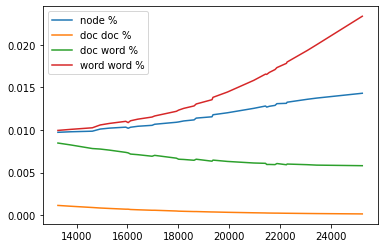

In [18]:
fig, ax = plt.subplots()

pdf = df.sort_values('total_nodes')

ax.plot(pdf['total_nodes'], pdf['node_perc'], label="node %")
ax.plot(pdf['total_nodes'], pdf['dd_perc'], label="doc doc %")
ax.plot(pdf['total_nodes'], pdf['dw_perc'], label="doc word %")
ax.plot(pdf['total_nodes'], pdf['ww_perc'], label="word word %")

plt.legend()

In [19]:
import numpy as np

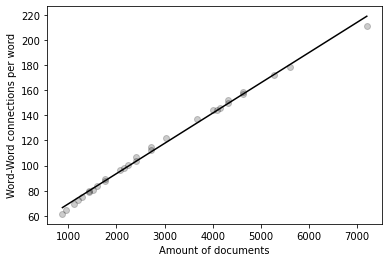

In [20]:
fig, ax = plt.subplots()

pdf = df.sort_values('total_nodes')

x = pdf['total_docs']
y = pdf['ww_ave']

# ax.plot(pdf['total_nodes'], pdf['node_ave'], label="node cons per node")
# ax.plot(pdf['total_nodes'], pdf['dd_ave'], label="doc doc cons per doc")
# ax.plot(pdf['total_nodes'], pdf['dw_ave'], label="doc word cons per doc")
ax.scatter(x, y, label="word word cons per word", color="black", alpha=0.2)

ax.set_xlabel("Amount of documents")
ax.set_ylabel("Word-Word connections per word")

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b, color="black")

plt.savefig('results/images/scriptie_2a.jpg', format='jpg', bbox_inches='tight')
plt.show()

In [21]:
df.to_csv("results/graphdensity.csv")

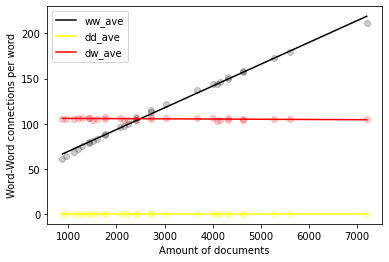

In [22]:
fig, ax = plt.subplots()

pdf = df.sort_values('total_nodes')

colors = ['black', 'yellow', 'red', 'blue', 'pink']
columns = ['ww_ave', 'dd_ave', 'dw_ave']


for color, column in zip(colors, columns):
    x = pdf['total_docs']
    y = pdf[column]
    
    ax.scatter(x, y, color=color, alpha=0.2)

    ax.set_xlabel("Amount of documents")
    ax.set_ylabel("Word-Word connections per word")

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x + b, color=color, label=column)

plt.legend()
plt.savefig('results/images/scriptie_2aALT.jpg', format='jpg', bbox_inches='tight')
plt.show()